In [1]:
import scipy.io as scipy
import os
import os.path as osp
import pandas as pd
import numpy as np
import pickle
import networkx as nx
from tqdm import tqdm
import copy

In [2]:
BASEDIR = os.getcwd()
MAP_NAME = 'UtrechtReduced.mat'
REQ_NAME = 'RequestsUtrechtReduced.mat'
OUTPUT_NAME = 'Utrecht' 


In [3]:
map = scipy.loadmat(osp.join(BASEDIR, MAP_NAME))
# map.keys()
# turn all the data into a pandas dataframe
# ['AdjacencyV', 'Dictionary', 'DijkstraV', 'DijkstraW', 'EdgesModified', 'Nodes', 'PartialPaths']

AdjacencyV = pd.DataFrame(map['AdjacencyV'])
Dictionary = pd.DataFrame(map['Dictionary'])
DijkstraV = pd.DataFrame(map['DijkstraV'])
DijkstraW = pd.DataFrame(map['DijkstraW'])
EdgesModified = pd.DataFrame(map['EdgesModified'])
Nodes = pd.DataFrame(map['Nodes'])
PartialPaths = pd.DataFrame(map['PartialPaths'])


In [15]:
EdgesModified.head()

,0,1,2
0,1.0,7572.0,0.042819
1,1.0,7800.0,0.052293
2,2.0,4048.0,0.091146
3,2.0,4142.0,0.364368
4,3.0,3445.0,0.102636


In [10]:
Nodes.iloc[0]

0    52.080200
1     5.121694
Name: 0, dtype: float64

In [11]:
Nodes.head()

,0,1
0,52.080200,5.121694
1,52.090593,5.104264
2,52.083792,5.084602
3,52.081178,5.125704
4,52.090024,5.114095


In [5]:
# 筛选出第三列小于 10^6 的行
map_Edges = EdgesModified[EdgesModified.iloc[:, 2] < 10**6].copy()

# 重命名列
map_Edges.columns = ['Oid', 'Did', 'ArcTime']

# 转换 'Oid' 和 'Did' 列为整数类型
map_Edges['Oid'] = map_Edges['Oid'].astype(int)
map_Edges['Did'] = map_Edges['Did'].astype(int)

# 将 'ArcTime' 列转换为秒
map_Edges['ArcTime'] = map_Edges['ArcTime'] * 60

# save arcs as pickle
with open(osp.join(BASEDIR,OUTPUT_NAME + '_Edges.pkl'), 'wb') as f:
    pickle.dump(map_Edges, f)
    
# 显示结果
map_Edges

,Oid,Did,ArcTime
0,1,7572,2.569140
1,1,7800,3.137580
2,2,4048,5.468760
3,2,4142,21.862080
4,3,3445,6.158160
...,...,...,...
22954,9297,7416,11.366400
22955,9297,7420,11.366400
22956,9326,9318,6.018000
22957,9420,5166,15.173040


/var/folders/mx/4dvj2kmn4x9736lbscg7224m0000gp/T/ipykernel_82851/2045568763.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  map_Nodes['zone_id'].fillna(-1, inplace=True)


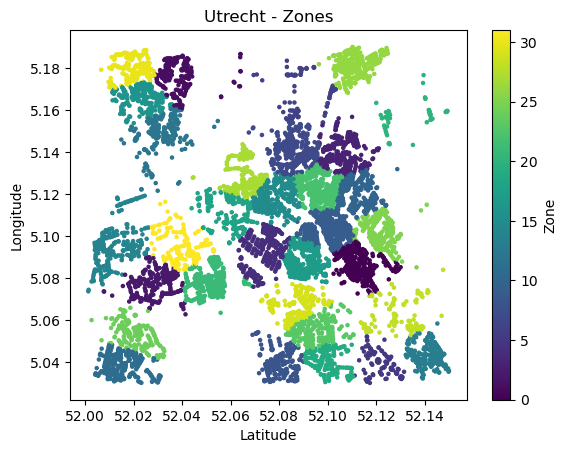

,node_id,latitude,longitude,is_connected,zone_id
0,1,52.080200,5.121694,True,15
1,2,52.090593,5.104264,True,9
2,3,52.083792,5.084602,True,17
3,4,52.081178,5.125704,True,15
4,5,52.090024,5.114095,True,22
...,...,...,...,...,...
9611,9612,52.021798,5.078844,True,2
9612,9613,52.073887,5.105430,True,4
9613,9614,52.097190,5.069101,False,-1
9614,9615,52.020462,5.165404,True,16


In [12]:
import copy
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 复制并重置索引
map_Nodes = copy.deepcopy(Nodes)
map_Nodes.reset_index(drop=True, inplace=True)
map_Nodes = map_Nodes.reset_index()
map_Nodes.columns = ['node_id', 'latitude', 'longitude']
map_Nodes['node_id'] = map_Nodes['node_id'] + 1

# 获取所有在 map_Edges 中出现的节点（即非孤立节点）
connected_nodes = set(map_Edges['Oid']).union(set(map_Edges['Did']))
map_Nodes['is_connected'] = map_Nodes['node_id'].apply(lambda x: x in connected_nodes)

# 提取非孤立节点的坐标
coordinates = map_Nodes[map_Nodes['is_connected']][['latitude', 'longitude']].values

# 执行聚类
k = 32
kmeans = KMeans(n_clusters=k, random_state=0).fit(coordinates)

# 将聚类结果分配给非孤立节点
map_Nodes.loc[map_Nodes['is_connected'], 'zone_id'] = kmeans.labels_

# 对于孤立节点，设置 zone_id 为 -1
map_Nodes['zone_id'].fillna(-1, inplace=True)

map_Nodes['zone_id'] = map_Nodes['zone_id'].astype(int)

# 过滤掉孤立节点（zone_id 为 -1 的节点）
non_isolated_nodes = map_Nodes[map_Nodes['zone_id'] != -1]

# 可视化聚类结果，不包括孤立节点
plt.scatter(non_isolated_nodes['latitude'], non_isolated_nodes['longitude'], 
            c=non_isolated_nodes['zone_id'], cmap='viridis', s= 5)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Utrecht - Zones')
plt.colorbar(label='Zone')
plt.savefig(osp.join(BASEDIR, OUTPUT_NAME + '_Node_Clustering.png'), dpi=300)
plt.show()

# 保存结果
map_Nodes.to_csv(osp.join(BASEDIR, OUTPUT_NAME + '_Nodes.csv'), index=False)

# pickle
with open(osp.join(BASEDIR, OUTPUT_NAME + '_Nodes.pkl'), 'wb') as f:
    pickle.dump(map_Nodes, f)
    
map_Nodes


In [7]:
# 创建网络图，并添加所有节点和边
G = nx.DiGraph()

# 添加所有节点
for node_id in map_Nodes['node_id']:
    G.add_node(node_id)

# 添加边
num_edges = len(map_Edges)
arcs = tqdm(map_Edges.iterrows(), total=num_edges, ncols=100, desc='Building network...')
for idx, arc in arcs:
    Oid = arc['Oid']
    Did = arc['Did']
    TimeCost = arc['ArcTime']
    G.add_edge(Oid, Did, TimeCost=TimeCost)

print(f'Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')

# 初始化邻接矩阵
area_adjacency_matrix = np.zeros((k, k), dtype=int)

# 检查邻接关系
for node in map_Nodes[map_Nodes['is_connected']]['node_id']:
    node_zone = map_Nodes.loc[map_Nodes['node_id'] == node, 'zone_id'].values[0]
    neighbors = list(G.neighbors(node))

    for neighbor in neighbors:
        neighbor_zone = map_Nodes.loc[map_Nodes['node_id'] == neighbor, 'zone_id'].values[0]

        # 标记不同区域间的直接相邻关系
        if node_zone != neighbor_zone and neighbor_zone != -1:
            area_adjacency_matrix[node_zone, neighbor_zone] = 1
            area_adjacency_matrix[neighbor_zone, node_zone] = 1  # 确保对称

# 添加自环
np.fill_diagonal(area_adjacency_matrix, 1)


# 输出并保存邻接矩阵
print("Area Adjacency Matrix:")
print(area_adjacency_matrix)

# # 保存邻接矩阵到CSV
# np.savetxt(osp.join(BASEDIR, OUTPUT_NAME + '_Area_Adjacency_Matrix.csv'), area_adjacency_matrix, delimiter=",", fmt='%d')

# 保存邻接矩阵到pickle
with open(osp.join(BASEDIR, OUTPUT_NAME + '_Zone_Adjacency_Matrix.pkl'), 'wb') as f:
    pickle.dump(area_adjacency_matrix, f)

Building network...: 100%|█████████████████████████████████| 19399/19399 [00:00<00:00, 70424.50it/s]


Network has 9616 nodes and 19399 edges.
Area Adjacency Matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 1 0]
 [0 0 1 ... 0 0 1]]


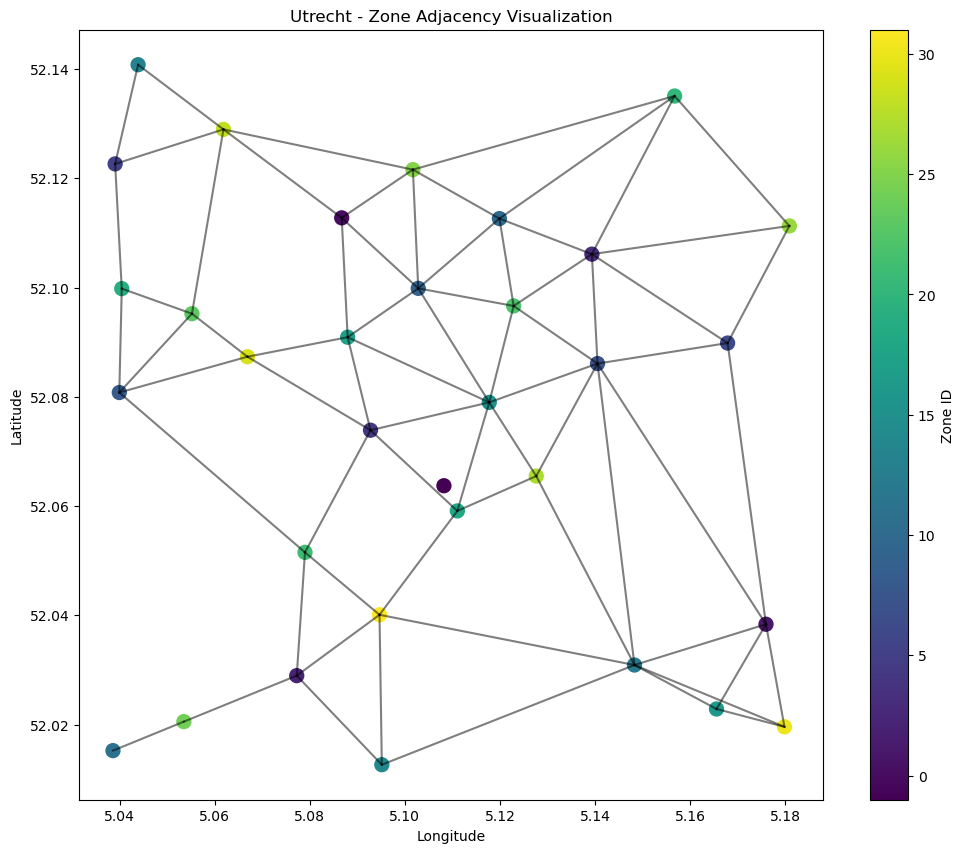

In [8]:
# 计算每个区域的质心
centroids = map_Nodes.groupby('zone_id')[['latitude', 'longitude']].mean()

# 创建图
plt.figure(figsize=(12, 10))

# 绘制每个区域的质心
plt.scatter(centroids['longitude'], centroids['latitude'], c=centroids.index, cmap='viridis', s=100, label='Zone Centroids')
plt.colorbar(label='Zone ID')

# 根据邻接矩阵绘制相邻区域之间的连线
for i in range(k):
    for j in range(i+1, k):  # 避免重复绘制对称线
        if area_adjacency_matrix[i, j] == 1:
            # 获取相邻区域的质心
            lat1, lon1 = centroids.loc[i]
            lat2, lon2 = centroids.loc[j]
            # 绘制连接线
            plt.plot([lon1, lon2], [lat1, lat2], 'k-', alpha=0.5)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Utrecht - Zone Adjacency Visualization")

#save image
plt.savefig(osp.join(BASEDIR, OUTPUT_NAME + '_Zone_Adjacency_Visualization.png'), dpi=300)
plt.show()


In [9]:
# add one to index of column and row index make it 1-indexed
AdjacencyV.index = AdjacencyV.index + 1
AdjacencyV.columns = AdjacencyV.columns + 1

# Add self-Connection to AdjacencyV
for i in range(AdjacencyV.shape[0]):
    AdjacencyV.loc[i+1,i+1] = 1

# AdjacencyV.drop(AdjacencyV.index[-1], inplace=True) # remove last row
# AdjacencyV.drop(AdjacencyV.columns[0], axis=1, inplace=True) # remove first column
AdjacencyV = AdjacencyV.astype(int) # trun to integer

# save adjacency as pickle
with open(osp.join(BASEDIR,OUTPUT_NAME + 'Node_Adjacency_Matrix.pkl'), 'wb') as f:
    pickle.dump(AdjacencyV, f)

AdjacencyV

,1,2,3,4,5,6,7,8,9,10,...,9607,9608,9609,9610,9611,9612,9613,9614,9615,9616
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [10]:
# All Path Matrix
PartialPaths_copy = copy.deepcopy(PartialPaths) # AllPathMatrix, 0-indexed
PartialPaths_copy.index = PartialPaths_copy.index + 1
PartialPaths_copy.columns = PartialPaths_copy.columns + 1

# # add self-connection
# for i in range(PartialPaths_copy.shape[0]):
#     PartialPaths_copy.loc[i+1,i+1] = i+1
    
# Save All_Path_Matrix as pickle
with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathMatrix.pkl'), 'wb') as f:
    pickle.dump(PartialPaths_copy, f)

PartialPaths_copy

,1,2,3,4,5,6,7,8,9,10,...,9607,9608,9609,9610,9611,9612,9613,9614,9615,9616
1,0,7572,7572,7800,7572,7572,7572,7800,7572,7572,...,7572,7800,7572,7572,7800,7572,7572,7572,7572,7572
2,4142,0,4048,4142,4142,4142,4142,4142,4048,4048,...,4048,4142,4048,4048,4142,4048,4048,4048,4048,4048
3,8307,8307,0,8307,8307,8307,3445,8307,8307,8307,...,8307,8307,8307,8307,8307,8307,8307,8307,8307,8307
4,6912,6912,6912,0,6912,6912,6912,3279,3279,3279,...,3279,3279,3279,3279,3417,3279,6912,6912,3279,3279
5,9012,8949,8949,9012,0,9012,8949,9012,9012,9012,...,9012,9012,9012,9012,8949,9012,9012,8949,9012,9012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9612,811,811,811,811,811,811,811,811,811,811,...,811,811,811,811,811,0,811,811,811,811
9613,2889,2889,2889,2889,2889,2889,2889,2889,2889,2889,...,2889,2889,2889,2889,2889,2889,0,2889,2889,2889
9614,8873,8873,8873,8873,8873,8873,8873,8873,8873,8873,...,8873,8873,8873,8873,8873,8873,8873,0,8873,8873
9615,9616,9616,9616,9616,9616,9616,9616,9616,9616,9616,...,9616,9616,9616,9616,9616,9616,9616,9616,0,9616


In [11]:
# All Path Time Matrix
DijkstraV_copy = copy.deepcopy(DijkstraV) # AllPathTimeMatrix, 0-indexed
DijkstraV_copy.index = DijkstraV_copy.index + 1
DijkstraV_copy.columns = DijkstraV_copy.columns + 1

DijkstraV_copy[DijkstraV_copy[:][:] > 10**6] = None
with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathTimeMatrix.pkl'), 'wb') as f:
    pickle.dump(DijkstraV_copy, f)

In [110]:
# load pickle and test
with open(osp.join(BASEDIR,OUTPUT_NAME + '_Edges.pkl'), 'rb') as f:
    map_Edges = pickle.load(f)

with open(osp.join(BASEDIR,OUTPUT_NAME + '_adjacency.pkl'), 'rb') as f:
    map_adjacency = pickle.load(f)

with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathMatrix.pkl'), 'rb') as f:
    map_AllPathMatrix = pickle.load(f)

with open(osp.join(BASEDIR,OUTPUT_NAME + '_AllPathTimeMatrix.pkl'), 'rb') as f:
    map_AllPathTimeMatrix = pickle.load(f)

In [40]:
# Requests
map = scipy.loadmat(osp.join(BASEDIR, REQ_NAME))
Requests = copy.deepcopy(pd.DataFrame(map['RequestsUtrecht']))

In [41]:
# Rename columns
Requests.columns = ['Oid', 'Did', 'ReqTime', 'Size']

# Random multiply Size
size_prob = [0.7, 0.2, 0.1]  # 1: 70%, 2: 20%, 3: 10%
length = len(Requests)
size_multiplier_array = np.random.choice([1, 2, 3], size=length, p=size_prob)

Requests['Size'] = Requests['Size'] * size_multiplier_array

# Convert ReqTime to seconds
Requests['ReqTime'] = Requests['ReqTime'] * 60

# Covnert everything to integer
Requests['Oid'] = Requests['Oid'].astype(int)
Requests['Did'] = Requests['Did'].astype(int)
Requests['Size'] = Requests['Size'].astype(int)
Requests['ReqTime'] = Requests['ReqTime'].astype(int)

# order by ReqTime
Requests = Requests.sort_values(by='ReqTime')

# add ReqID
Requests['ReqID'] = np.arange(1, len(Requests)+1, 1)

# Put ReqID as first column
Requests = Requests[['ReqID', 'Oid', 'Did', 'ReqTime', 'Size']]

# Drop Index
Requests.reset_index(drop=True, inplace=True)

# Save Requests as CSV
Requests.to_csv(osp.join(BASEDIR,OUTPUT_NAME + '_Requests.csv'), index=False)

Requests


,ReqID,Oid,Did,ReqTime,Size
0,1,6593,5605,0,2
1,2,5250,7064,0,1
2,3,9184,4255,0,2
3,4,7851,2712,1,2
4,5,5550,1899,1,1
...,...,...,...,...,...
26892,26893,2140,9439,10798,1
26893,26894,2602,4268,10798,1
26894,26895,4249,2579,10798,1
26895,26896,7499,8194,10799,1


In [6]:
# read Requests and nodes
REQ_PATH = osp.join(BASEDIR,OUTPUT_NAME + '_Requests.csv')
NODE_PATH = osp.join(BASEDIR,OUTPUT_NAME + '_Nodes.csv')

requests = pd.read_csv(REQ_PATH)
nodes = pd.read_csv(NODE_PATH)

# filter out isolated nodes
not_connected_nodes = nodes[nodes['is_connected'] == False]
# save isolated nodes as pkl, list, only contain nodeID
with open(osp.join(BASEDIR,OUTPUT_NAME + '_IsolatedNodes.pkl'), 'wb') as f:
    pickle.dump(not_connected_nodes['node_id'].tolist(), f)



In [ ]:
# load pickle and test
with open(osp.join(BASEDIR,OUTPUT_NAME + '_Edges.pkl'), 'rb') as f:
    map_Edges = pickle.load(f)